In [2]:
from IPython.display import Image

# RNN

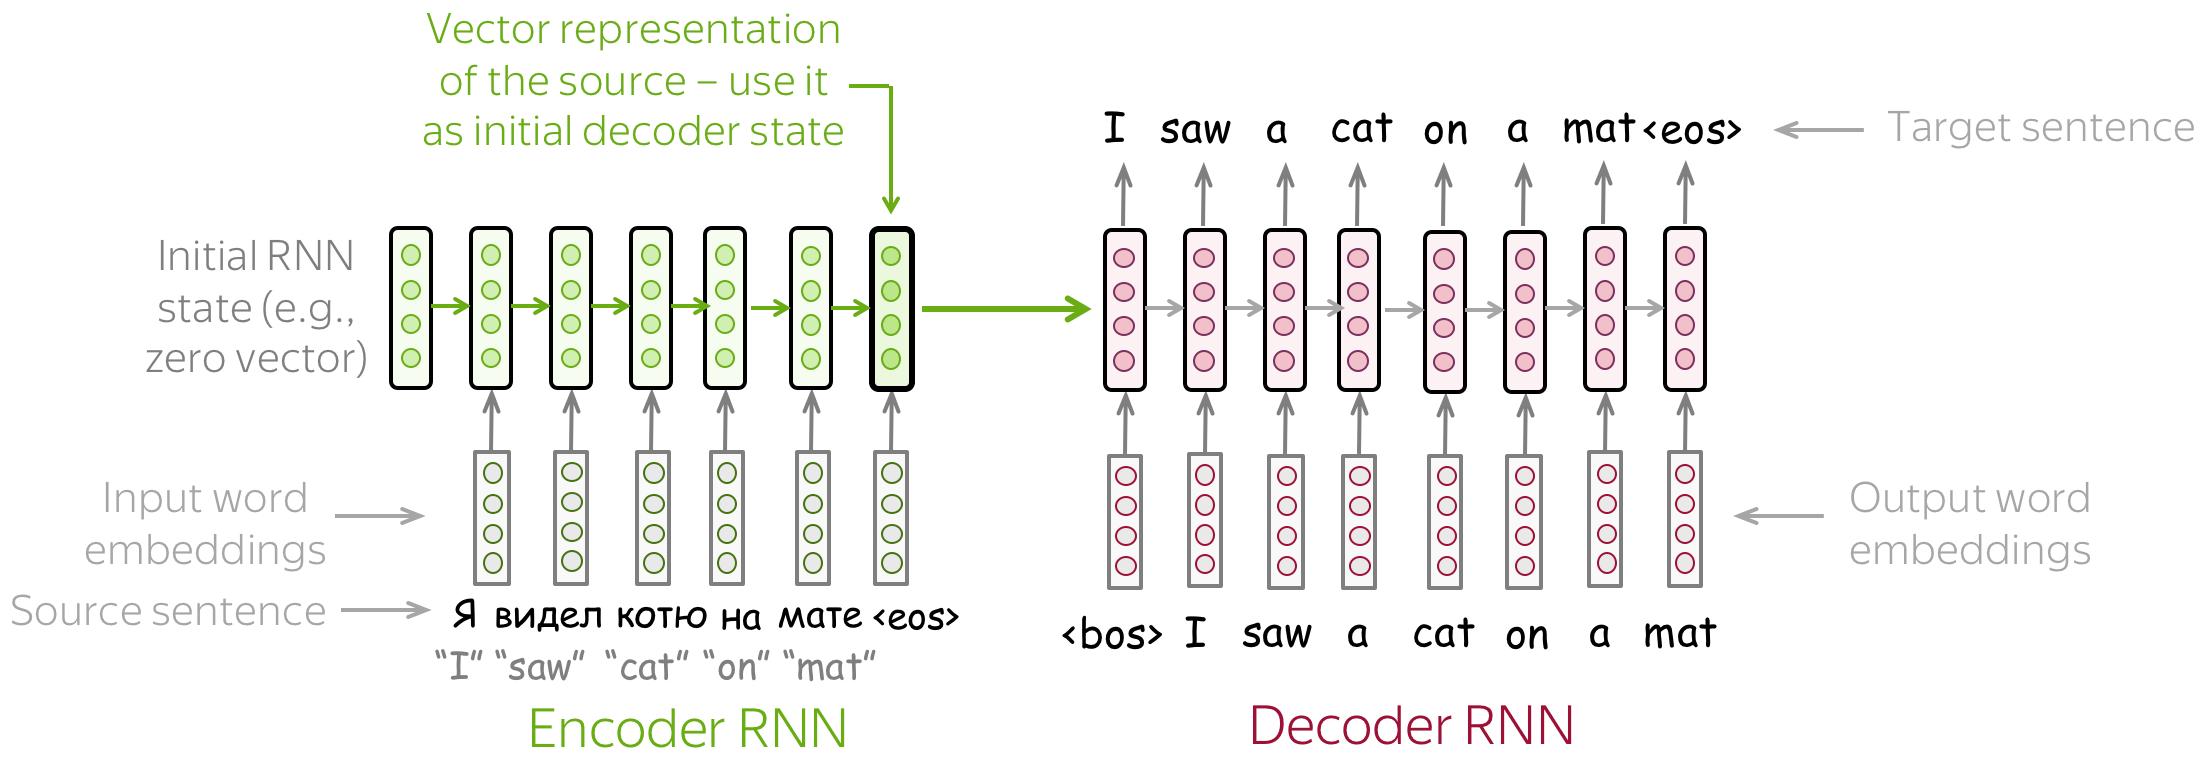

In [4]:
Image('images/enc_dec_simple_rnn-min.png', width=600)

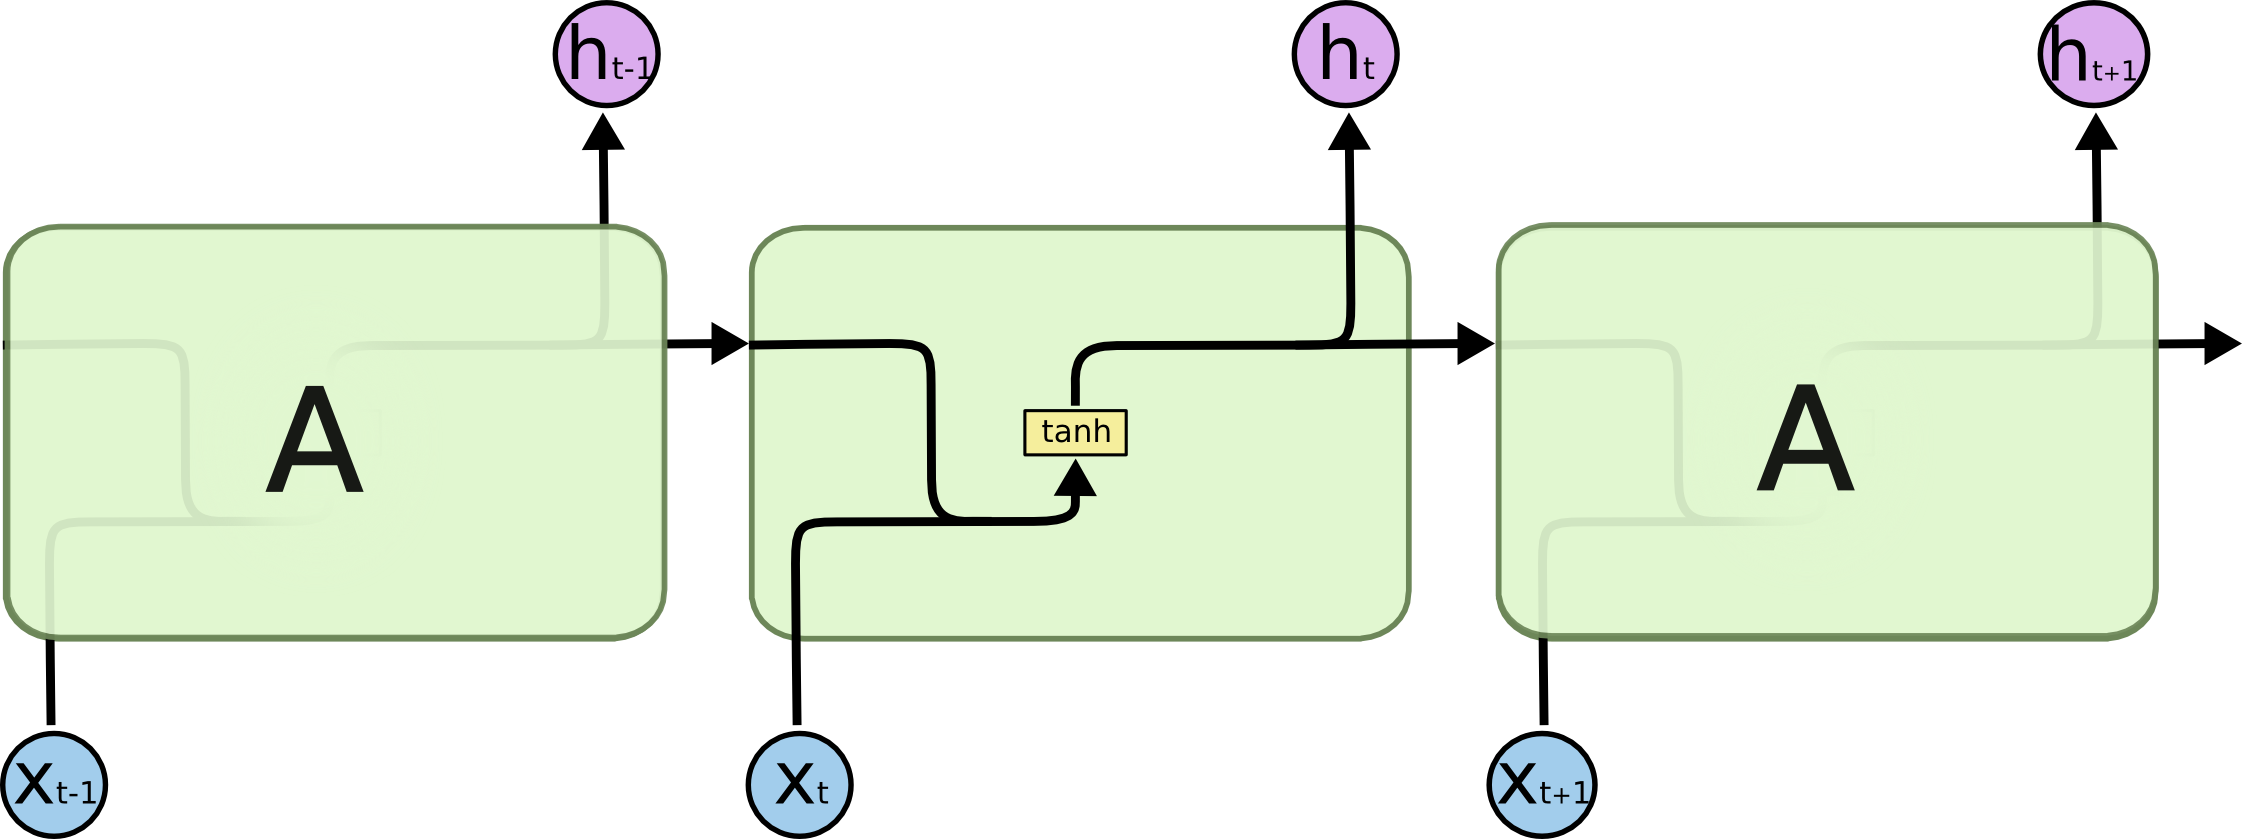

In [9]:
Image('images/RNN_layer.png', width=600)

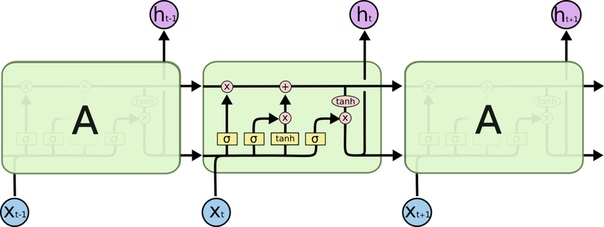

In [10]:
Image('images/lstm.jpg', width=600)

In [14]:
from IPython.display import Video

Video("images/enc_dec_prob_idea.mp4", width=600)

# BERT
<img src = "https://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png" width = 600>

## Attention

[Self-attention](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a)

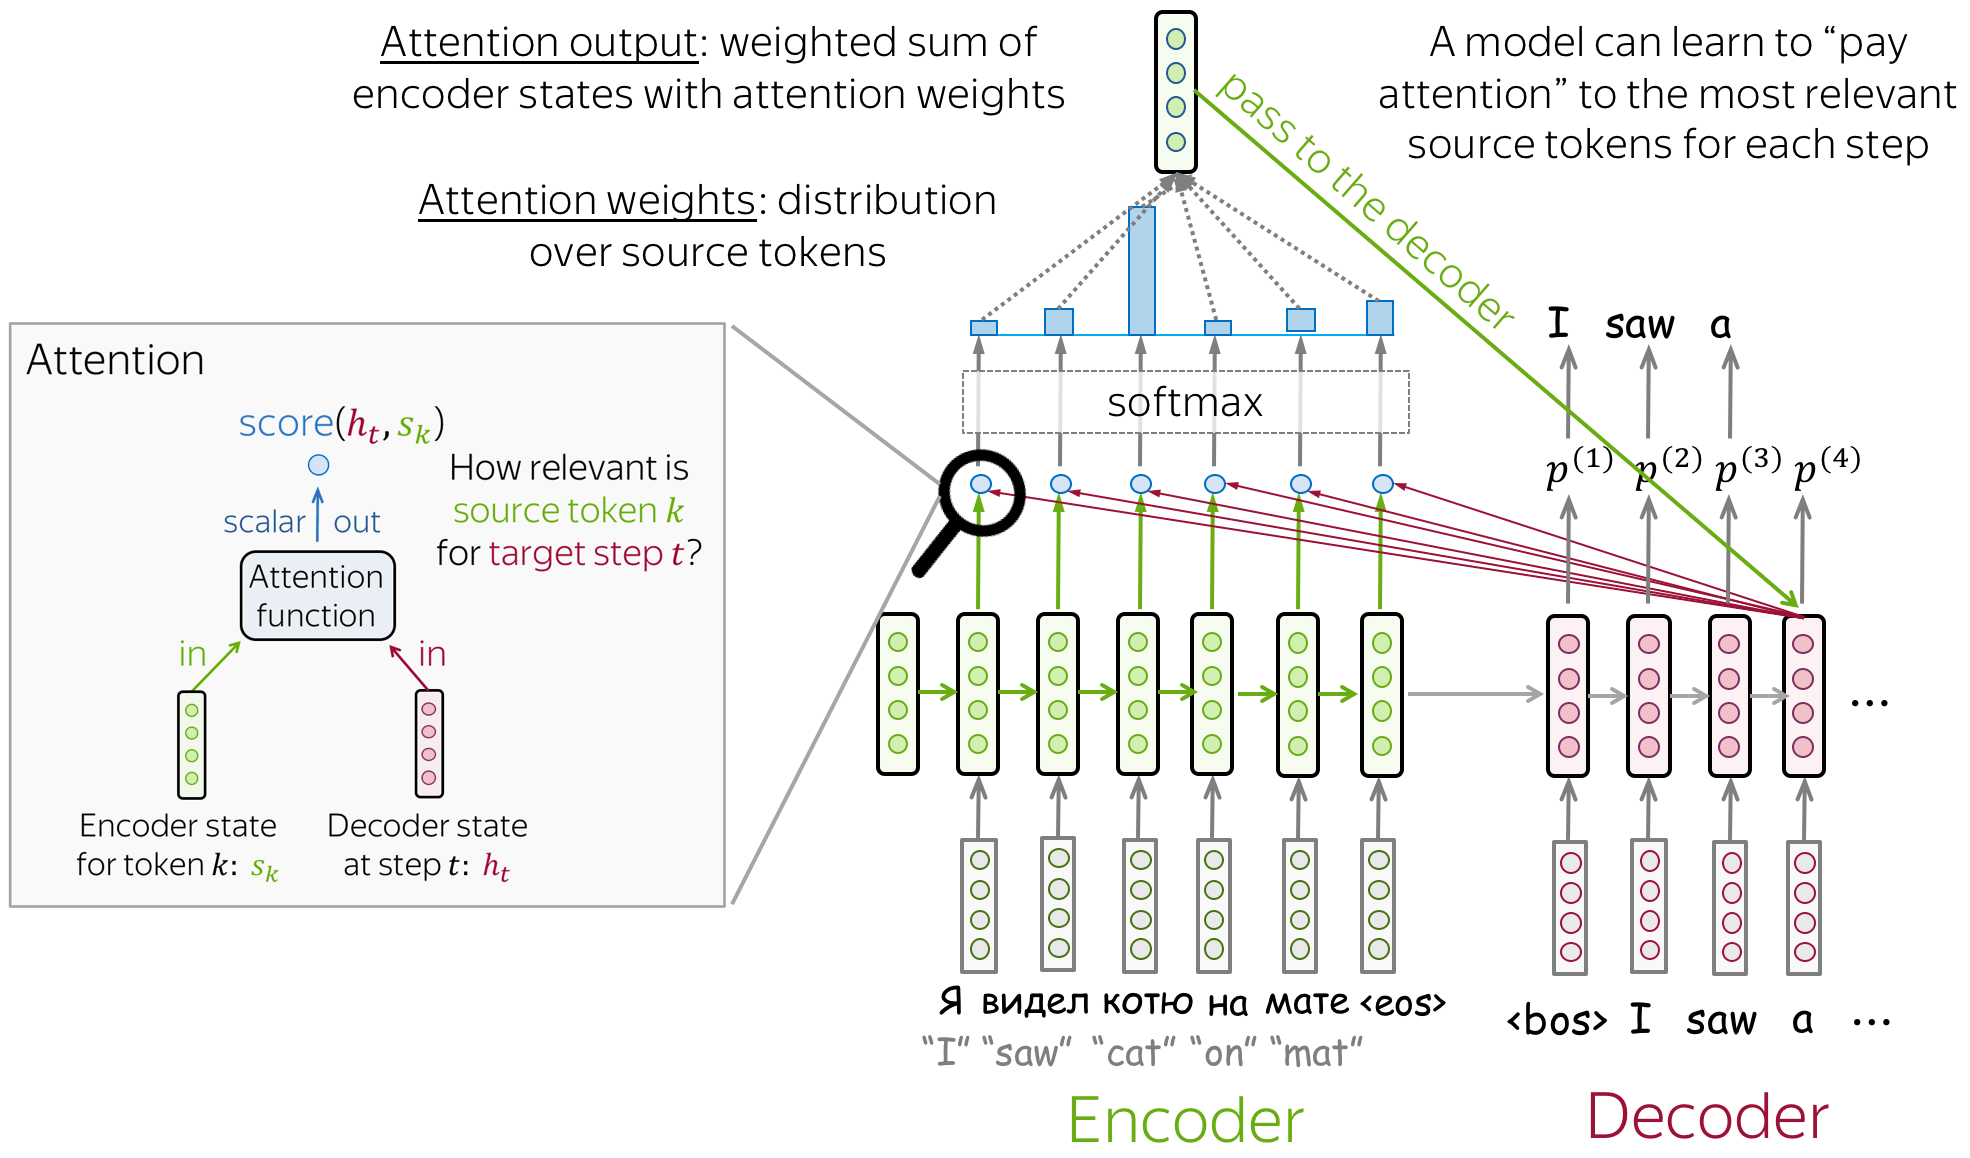

In [13]:
Image('images/attention.png', width=600)

## 1. Importing Libraries

In [1]:
! pip install pytorch_pretrained_bert pytorch-nlp -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from bs4 import BeautifulSoup
import re

from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
import torch
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from torch.nn import BCEWithLogitsLoss, Sigmoid

from tqdm.notebook import tqdm, trange

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.Reading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/ml2021/jigsaw-toxic-comment-classification-challenge.zip

In [3]:
!unzip -o '/content/*.zip' 


4 archives were successfully processed.


In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

print(df_train.shape, df_test.shape, sample_submission.shape)
df_train.head()

(159571, 8) (153164, 2) (153164, 7)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## 3. Text Preprocessing

First of all let's clean the data:
1. Cleaning the html tags using BeautifulSoup
2. Removing non-alphanumeric data

In [5]:
def strip(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = re.sub('\[[^]]*\]', '', soup.get_text())
    pattern=r"[^a-zA-z0-9\s,']"
    text=re.sub(pattern,'',text)
    return text

df_train["comment_text"] = df_train["comment_text"].apply(strip)
df_test["comment_text"] = df_test["comment_text"].apply(strip)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:398: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup
/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:398: UserWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup
/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:398: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia:ELYES" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, a

In [6]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww He matches this background colour I'm se...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war It'...",0,0,0,0,0,0
3,0001b41b1c6bb37e,\nMore\nI can't make any real suggestions on i...,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero Any chance you remember ...",0,0,0,0,0,0


Pretraining for input to BERT:

1. The first token of every sequence is always a special classification token ([CLS]).
2. We separate the sentences with a special token ([SEP])

In [7]:
train_sentences = df_train["comment_text"]
test_sentences = df_test["comment_text"]
train_sentences = ["[CLS] "+ i + " [SEP]"for i in train_sentences]
test_sentences = ["[CLS] "+ i + " [SEP]"for i in test_sentences]
train_sentences[0], test_sentences[0]

("[CLS] Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC And please don't remove the template from the talk page since I'm retired now892053827 [SEP]",
 "[CLS] Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckasi should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me Ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother toofuckin white boys get things right next time, [SEP]")

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary. The tokenization must be performed by the tokenizer included with BERT. We’ll be using the “uncased” version here. 

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

train_tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t)[:510], tqdm(train_sentences)))

test_tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t)[:510], tqdm(test_sentences)))

np.array(train_tokenizer_texts[0]), np.array(test_tokenizer_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 5555958.86B/s]


(array(['[CLS]', 'explanation', 'why', 'the', 'edit', '##s', 'made',
        'under', 'my', 'user', '##name', 'hardcore', 'metallic', '##a',
        'fan', 'were', 'reverted', 'they', 'weren', "'", 't', 'van',
        '##dal', '##isms', ',', 'just', 'closure', 'on', 'some', 'gas',
        'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fa', '##c',
        'and', 'please', 'don', "'", 't', 'remove', 'the', 'template',
        'from', 'the', 'talk', 'page', 'since', 'i', "'", 'm', 'retired',
        'now', '##8', '##9', '##20', '##53', '##8', '##27', '[SEP]'],
       dtype='<U11'),
 array(['[CLS]', 'yo', 'bitch', 'ja', 'rule', 'is', 'more', 'su', '##cc',
        '##es', '##ful', 'then', 'you', "'", 'll', 'ever', 'be', 'what',
        '##s', 'up', 'with', 'you', 'and', 'hating', 'you', 'sad', 'mo',
        '##fu', '##ck', '##asi', 'should', 'bitch', 'slap', 'ur', 'pet',
        '##hed', '##ic', 'white', 'faces', 'and', 'get', 'you', 'to',
        'kiss', 'my', 'ass', 'you', 'guys', 

In [9]:
labels = df_train[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].to_numpy()

The sentences in our dataset obviously have varying lengths. BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.
Padding is done with a special [PAD] token, which is at index 0 in the BERT vocabulary. 

In [10]:
#Padding/truncating the train and test sentences to a size of 128 tokens per sentence

MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(train_tokenizer_texts)]
input_ids = pad_sequences(sequences = input_ids, maxlen = MAX_LEN, dtype = 'long', padding='post', truncating='post')

test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(test_tokenizer_texts)]
test_input_ids = pad_sequences(sequences = test_input_ids, maxlen = MAX_LEN, dtype = 'long', padding='post', truncating='post')


input_ids[0], test_input_ids[0]

(array([  101,  7526,  2339,  1996, 10086,  2015,  2081,  2104,  2026,
         5310, 18442, 13076, 12392,  2050,  5470,  2020, 16407,  2027,
         4694,  1005,  1056,  3158,  9305, 22556,  1010,  2074,  8503,
         2006,  2070,  3806,  2044,  1045,  5444,  2012,  2047,  2259,
        14421,  6904,  2278,  1998,  3531,  2123,  1005,  1056,  6366,
         1996, 23561,  2013,  1996,  2831,  3931,  2144,  1045,  1005,
         1049,  3394,  2085,  2620,  2683, 11387, 22275,  2620, 22907,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [11]:
#Creating an attention mask - For actual tokens its set to 1, for padding tokens its set to 0
def create_attention_masks(input_ids):
    attention_masks = []
    for seq in tqdm(input_ids):
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return np.array(attention_masks)

attention_masks = create_attention_masks(input_ids)
test_attention_masks = create_attention_masks(test_input_ids)
attention_masks[0], test_attention_masks[0]

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.

In [12]:
# Use train_test_split to split our data and attention masks into train and validation sets for training
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, random_state = 123, test_size = 0.20)
attention_masks_train, attention_masks_val = train_test_split(attention_masks, random_state = 123, test_size = 0.20)

In [13]:
# Convert all inputs and labels into torch tensors, the required datatype 
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
y_train = torch.tensor(y_train) 
y_val = torch.tensor(y_val)
attention_masks_train = torch.tensor(attention_masks_train)
attention_masks_val = torch.tensor(attention_masks_val)

test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)

In [14]:
y_val.shape

torch.Size([31915, 6])

We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory. In Training we need to randomize the data for generalizing better so we use random sampler. We dont need that while predicting in validation or test set so we use sequential sampler.

In [15]:
BATCH_SIZE = 32
#Dataset wrapping tensors.
train_data = TensorDataset(X_train, attention_masks_train, y_train)
val_data = TensorDataset(X_val, attention_masks_val, y_val)
test_data = TensorDataset(test_input_ids, test_attention_masks)
#Samples elements randomly. If without replacement(default), then sample from a shuffled dataset.
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)
test_sampler = SequentialSampler(test_data)
#represents a Python iterable over a dataset
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = BATCH_SIZE)

## 4. Loading pre trained BERT and setting fine-tuning parameters
First we load the bert model for sequence classification. We set the output neurons to 6 as we have 6 toxic types to be predicted for as yes or no.

Next, we get weights for various layers and put them into a single list. Once that is done, we separate weight parameters (which needs to be updated) from bias, gamma, and beta parameters (which don't need to be updated). We filter one group without these values and another with them. Hence you see one group with weight_decay_rate 0.01 and another 0.0.

In [ ]:
#Inititaing a BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 6)
model.cuda()

In [17]:
#Dividing the params into those which needs to be updated and rest
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01
    },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0
    }
]

optimizer = BertAdam(optimizer_grouped_parameters, lr = 2e-5, warmup = .1)

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.
For the purposes of fine-tuning, the authors recommend choosing from the following values:

Batch size: 16, 32 (We chose 32 when creating our DataLoaders).

Learning rate (Adam): 5e-5, 3e-5, 2e-5 (We’ll use 2e-5).

Number of epochs: 2, 3, 4 (We’ll use 2).

In [18]:
#freeing up memory
torch.cuda.empty_cache()
import gc
gc.collect()

264

## 5. Tuning the BERT model
This is the phase where we fine-tune the BERT model on our dataset for as much epochs as required and validate the model performance on Validation data

We will be using BCEWithLogitLoss function for calculating multi-label loss between predicted and actual values. This is similar to adding sigmoid function at the end of the network and calculating binary-cross entropy loss like in Keras we did for LSTM and CNN. 

In [19]:
#Empty the GPU memory as it might be memory and CPU intensive while training
torch.cuda.empty_cache()
#Number of times the whole dataset will run through the network and model is fine-tuned
epochs = 2
#Iterate over number of epochs
for _ in trange(epochs, desc = "Epoch"):
    #Switch model to train phase where it will update gradients
    model.train()
    #Initaite train and validation loss, number of rows passed and number of batches passed
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    val_loss = 0
    nb_val_examples, nb_val_steps = 0, 0
    #Iterate over batches within the same epoch
    for batch in tqdm(train_dataloader):
        #Shift the batch to GPU for computation
        batch = tuple(t.to(device) for t in batch)
        #Load the input ids and masks from the batch
        b_input_ids, b_input_mask, b_labels = batch
        #Initiate gradients to 0 as they tend to add up
        optimizer.zero_grad()
        #Forward pass the input data
        logits = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)
        #We will be using the Binary Cross entropy loss with added sigmoid function after that in BCEWithLogitsLoss
        loss_func = BCEWithLogitsLoss()
        #Calculate the loss between multilabel predicted outputs and actuals
        loss = loss_func(logits, b_labels.type_as(logits))
        #Backpropogate the loss and calculate the gradients
        loss.backward()
        #Update the weights with the calculated gradients
        optimizer.step()
        #Add the loss of the batch to the final loss, number of rows and batches
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    #Print the current training loss 
    print("Train Loss: {}".format(tr_loss/nb_tr_examples))
    #Switch the model to evaluate stage at which the gradients wont be updated
    model.eval()
    #Iterate over the validation data
    for step, batch in enumerate(val_dataloader):
        #Shift the validation data to GPUs for computation
        batch = tuple(t.to(device) for t in batch)
        #We dont want to update the gradients
        with torch.no_grad():
            #Load the input ids and masks from the batch
            b_input_ids, b_input_mask, b_labels = batch
            #Forward pass the input data
            logits = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)
            #We will be using the Binary Cross entropy loss with added sigmoid function after that in BCEWithLogitsLoss
            loss_func = BCEWithLogitsLoss()
            #Calculate the loss between multilabel predicted outputs and actuals
            loss = loss_func(logits, b_labels.type_as(logits))
            #Add the loss of the batch to the final loss, number of rows and batches
            val_loss += loss.item()
            nb_val_examples += b_input_ids.size(0)
            nb_val_steps += 1
    #Print the current validation loss     
    print("Valid Loss: {}".format(val_loss/nb_val_examples))

/opt/conda/lib/python3.7/site-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  next_m.mul_(beta1).add_(1 - beta1, grad)



Train Loss: 0.001545758034314055
Valid Loss: 0.0014397342384499738



Train Loss: 0.0011043809139282186
Valid Loss: 0.0012522008164762676



## 6. Predicting and Submitting for Test Data

In [20]:
outputs = []

#Iterate over the test_loader 
for step, batch in enumerate(test_dataloader):
        #Transfer batch to GPUs
        batch = tuple(t.to(device) for t in batch)
        #We dont need to update gradients as we are just predicting
        with torch.no_grad():
            #Bring up the next batch of input_texts and attention_masks 
            b_input_ids, b_input_mask = batch
            #Forward propogate the inputs and get output as logits
            logits = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)
            #Pass the outputs through a sigmoid function to get the multi-label preditions
            s = Sigmoid()
            out = s(logits).to('cpu').numpy()    
            #Add the predictions for this batch to the final list
            outputs.extend(out)
            
#Merge test df and submission table to have all columns in a table
df_test = pd.merge(df_test, sample_submission, on = "id")
#Assign the predictions to the toxic_output columns
df_test[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = outputs
#Drop text data as it is not expected in the submission file
df_test.drop(["comment_text"], axis = 1, inplace = True)
#Saving the submission dataframe
df_test.to_csv("sample_submission.csv", index = False)

## 0. Introduction

Before the introduction of Transformers, most state-of-the-art NLP systems relied on gated recurrent neural networks (RNNs), such as LSTMs and gated recurrent units (GRUs), with added attention mechanisms. The Transformer built on these attention technologies without using an RNN structure, highlighting the fact that the attention mechanisms alone, without recurrent sequential processing, are powerful enough to achieve the performance of RNNs with attention and are more parallelizable and requiring significantly less time to train.

**What are Transformer Networks?**
<img src = "https://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png" width = 600>
In a machine translation application, it would take a sentence in one language, and output its translation in another. Inside we see an encoding component, a decoding component, and connections between them. The encoding component is composed of a stack of N = 6 identical layers.The decoding component is a stack of decoders of the same number.

The encoder’s inputs first flow through a self-attention layer – a layer that helps the encoder look at other words in the input sentence as it encodes a specific word. The outputs of the self-attention layer are fed to a feed-forward neural network. The exact same feed-forward network is independently applied to each position. The decoder has both those layers, but between them is an attention layer that helps the decoder focus on relevant parts of the input sentence

As is the case in NLP applications in general, we begin by turning each input word into a vector using an embedding algorithm. The embedding only happens in the bottom-most encoder. The abstraction that is common to all the encoders is that they receive a list of vectors each of the size 512 – In the bottom encoder that would be the word embeddings, but in other encoders, it would be the output of the encoder that’s directly below.

**N.B.:** The word in each position flows through its own path in the encoder. There are dependencies between these paths in the self-attention layer. The feed-forward layer does not have those dependencies, however, and thus the various paths can be executed in parallel while flowing through the feed-forward layer.

**Self-Attention:**
Self-attention is the method the Transformer uses to bake the “understanding” of other relevant words into the one we’re currently processing.

Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequencealigned RNNs or convolution.

The first step in calculating self-attention is to create three vectors from each of the encoder’s input vectors (the embedding of each word). So for each word, we create a Query vector, a Key vector, and a Value vector. These vectors are created by multiplying the embedding by three matrices that we trained during the training process.Their dimensionality is 64, while the embedding and encoder input/output vectors have dimensionality of 512. This is an architecture choice to make the computation of multiheaded attention constant.

The second step in calculating self-attention is to calculate a score. Say we’re calculating the self-attention for the first word. We need to score each word of the input sentence against this word. The score determines how much focus to place on other parts of the input sentence as we encode a word at a certain position. The score is calculated by taking the dot product of the query vector with the key vector of the respective word we’re scoring. So if we’re processing the self-attention for the word in position #1, the first score would be the dot product of q1 and k1. The second score would be the dot product of q1 and k2.

The third and forth steps are to divide the scores by 8 (the square root of the dimension of the key vectors used – 64. This leads to having more stable gradients. Then pass the result through a softmax operation. Softmax normalizes the scores so they’re all positive and add up to 1.

The fifth step is to multiply each value vector by the softmax score. The intuition here is to keep intact the values of the word(s) we want to focus on, and drown-out irrelevant words (by multiplying them by tiny numbers like 0.001, for example).

The sixth step is to sum up the weighted value vectors. This produces the output of the self-attention layer at this position (for the first word).

The resulting vector is one we can send along to the feed-forward neural network. In the actual implementation, this calculation is done in matrix form for faster processing. 

**Multi-headed Self Attention**
The paper further refined the self-attention layer by adding a mechanism called “multi-headed” attention. This improves the performance of the attention layer in two ways:

1. It expands the model’s ability to focus on different positions. Yes, in the example above, the final result contains a little bit of every other encoding, but it could be dominated by the the actual word itself. It would be useful if we’re translating a sentence like “The animal didn’t cross the street because it was too tired”, we would want to know which word “it” refers to.

2. It gives the attention layer multiple “representation subspaces”. With multi-headed attention, we have 8 sets of Query/Key/Value weight matrices. Each of these sets is randomly initialized. Then, after training, each set is used to project the input embeddings into a different representation subspace.

We concat the multiple matrices then multiple them by an additional weights matrix WO so that they can be sent to the feedforward network.

<img src = "https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png" width = 600>

**Positional Encoding**
One thing that’s missing from the model as we have described it so far is a way to account for the order of the words in the input sequence. To address this, the transformer adds a vector to each input embedding. The intuition here is that adding these values to the embeddings provides meaningful distances between the embedding vectors once they’re projected into Q/K/V vectors and during dot-product attention. Values of the left half are generated by one function (which uses sine), and the right half is generated by another function (which uses cosine). They're then concatenated to form each of the positional encoding vectors.

**The Residuals**
Each sub-layer (self-attention, ffnn) in each encoder has a residual connection around it, and is followed by a layer-normalization step.For e.g. Add input matrix X (2 * 4) to output matrix Z (2 * 4) and normalize row wise.

**The Decoder Side**

<img src = "https://jalammar.github.io/images/t/transformer_decoding_2.gif"  width = 600>
The encoder start by processing the input sequence. The output of the top encoder is then transformed into a set of attention vectors K and V by multiplying with weight vectors. These are to be used by each decoder in its “encoder-decoder attention” layer which helps the decoder focus on appropriate places in the input sequence:

The following steps repeat the process until a special symbol is reached indicating the transformer decoder has completed its output. The output of each step is fed to the bottom decoder in the next time step, and the decoders bubble up their decoding results just like the encoders did. And just like we did with the encoder inputs, we embed and add positional encoding to those decoder inputs to indicate the position of each word.

The self attention layers in the decoder operate in a slightly different way than the one in the encoder:

In the decoder, the self-attention layer is only allowed to attend to earlier positions in the output sequence. This is done by masking future positions (setting them to -inf) before the softmax step in the self-attention calculation. The “Encoder-Decoder Attention” layer works just like multiheaded self-attention, except it creates its Queries matrix from the layer below it, and takes the Keys and Values matrix from the output of the encoder stack.

**The Final Linear and Softmax Layer**
The Linear layer is a simple fully connected neural network that projects the vector produced by the stack of decoders, into a much, much larger vector called a logits vector. Let’s assume that our model knows 10,000 unique English words ,that it’s learned from its training dataset. This would make the logits vector 10,000 cells wide – each cell corresponding to the score of a unique word. That is how we interpret the output of the model followed by the Linear layer. The softmax layer then turns those scores into probabilities (all positive, all add up to 1.0). The cell with the highest probability is chosen, and the word associated with it is produced as the output for this time step.

**Training**
Training is done by comparing the predicted values with the actuals using cross-entropy loss. Since, the model output one word at a time, we can use beam search to find the best output string



### BERT

Bidirectional Encoder Representations from Transformers. BERT is basically a trained Transformer Encoder stack. We
**pretrain** BERT to understand language and **fine-tune** BERT to learn specific task.
<img src="https://miro.medium.com/max/1400/1*LtF3nUFDhP62e9XAs6SlyQ.png" width="600">

**Pretraining:**
In the phase, BERT learns What is language? What is context? This is done by doing 2 things simultaneosuly:
1. Masked Language Moelling (MLM):
The masked language model randomly masks some of the tokens from the input, and the objective is to predict the original vocabulary id of the masked word based only on its context. For eg - The [MASK] brown fox jumped over the [MASK] dog. The MLM objective enables the representation to fuse the left and the right context, which allows us to pretrain a deep bidirectional Transformer. The training data generator chooses 15% of the token positions at random for prediction. If the i-th token is chosen, we replace the i-th token with (1) the [MASK] token 80% of the time (2) a random token 10% of the time (3)the unchanged i-th token 10% of the time.

2. Next Sentence Prediction (NSP): 
In this task, 2 sentences are taken and a binary classification is done if the two sentences are one after the another or not. A- Ajay is a cool dude B- He lives in Ohio.

**Input:** 
We pass in embedding vector for the input vector. This embedding vector is calculated from the input vector by summing the corresponding token, segment, and position embedding.
<img src="https://cdn.nextjournal.com/data/QmaXGoXqdcjopjVzG1xAQQMS1BsEECSEoxRgLqoeDdetv7?filename=2019-06-12%2000-50-16%20%E7%9A%84%E8%9E%A2%E5%B9%95%E6%93%B7%E5%9C%96.png&content-type=image/png" width = 600>

The segment and position encoding is used for the model to understand temporal positioning as these inputs are given simultaneously and not at a time step like in LSTMs. For token embeddings, we use WordPiece embeddings with a 30,000 token vocabulary.  Specifically, when choosing the sentences A and B for each pretraining example, 50% of the time B is the actual next sentence that follows A (labeled as IsNext), and 50% of the time it is a random sentence from the corpus (labeled as NotNext).

**Output:**
The output for the MLM is in the form of sentence vectors with masked tokens filled with the predicted tokens.
Each predicted token is then softmaxed over all the words in vocabulary and cross entropy loss is calculated against the actuals. This is done for the masked words.

The output for the NSP is the result for [CLS] token in the output. 

**Fine-tuning:**

<img src ="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/BERT-downstream-tasks_web.jpg" width = 500>
For each task, we simply plug in the task specific inputs and outputs into BERT and slightly finetune all the parameters end-to-end. Compared to pre-training, fine-tuning is relatively inexpensive and fast.
**Input:**
We pass in the sentence/ sentences in form of embedding (separated by [SEP] for 2 sentences for tasks like Question Answering. For tasks like classification, we can skip that)
**Output:**
For text classification, we will get the output in [CLS] token. For question answering tasks we get the Start and End Span.

The paper presents two model sizes for BERT (For, number of layers(i.e., Transformer blocks) as L, the hidden size as H and the number of self-attention heads as A):

BERTBASE (L=12, H=768, A=12, Total Parameters=110M)

BERTLARGE (L=24, H=1024,A=16, Total Parameters=340M).

For the pre-training corpus we use the BooksCorpus (800M words) and English Wikipedia (2,500M words).

These texts are largely taken from following resources:

http://jalammar.github.io/illustrated-transformer/

https://www.youtube.com/watch?v=xI0HHN5XKDo